In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer

plt.rcParams['figure.figsize'] = (8, 5)
plt.rcParams['axes.unicode_minus'] = False  


file_path = "/Users/chenxiaoyang/km6312/group/reddit_with_sentiment_labels.csv"  
df = pd.read_csv(file_path)
df = df.drop(columns=['Unnamed: 0'], errors='ignore')

df.head()

,comment_id,comment_parent_id,comment_body,subreddit,cleaned_comment,textblob_score,vader_score,combined_score,textblob_label,vader_label,combined_label
0,iztdxuh,t3_zj2aeu,"I've been shocked for days now, I don't need c...",r/ChatGPT,ive shock day dont need clickbait,0.000000,-0.3818,-0.381800,neutral,negative,negative
1,iztn0q0,t3_zj2aeu,\n\nI am so angry right now. I just wasted my...,r/ChatGPT,angry right wasted time read post sub clickbai...,-0.041327,-0.9758,-0.937832,neutral,negative,negative
2,izudrph,t3_zj2aeu,chatgpt karma whoring is here folks! just when...,r/ChatGPT,chatgpt karma whore folk think stream thought ...,0.300000,-0.8957,-0.595700,positive,negative,negative
3,iztfhtb,t3_zj2aeu,"Worked on me, ngl.",r/ChatGPT,work ngl,0.000000,0.0000,0.000000,neutral,neutral,neutral
4,izu2as9,t3_zj2aeu,"Certified 10/10, must-see moment. It really di...",r/ChatGPT,certify mustsee moment really shock core,0.200000,-0.4391,-0.239100,positive,negative,negative


In [3]:
print("Shape (rows, columns):", df.shape)
print("\n=== df.info() ===")
print(df.info())

print("\n=== Missing values per column ===")
print(df.isna().sum())

# Check duplicated comment IDs
dup_comment_ids = df['comment_id'].duplicated().sum()
print(f"\nNumber of duplicated comment_id: {dup_comment_ids}")

# Inspect subreddit values to detect possible header rows or noise
print("\n=== Unique subreddit values (first 20) ===")
print(df['subreddit'].dropna().unique()[:20])

# Identify obviously corrupted rows:
# - rows where 'subreddit' literally equals 'subreddit'
# - rows where 'comment_id' or 'comment_body' equals their own column name
# - rows where all columns are NaN

# rows where 'subreddit' literally equals 'subreddit'
mask_header_row = (df['subreddit'] == 'subreddit')

# rows where 'comment_id' or 'comment_body' equals their own column name
mask_like_header = (
    (df['comment_id'] == 'comment_id') |
    (df['comment_body'] == 'comment_body')
)

# rows where all columns are NaN
mask_all_na = df.isna().all(axis=1)

# NEW: rows where text fields are empty (no body and no subreddit)
mask_empty_text = (
    df['comment_body'].isna() &
    df['subreddit'].isna()
)

# combine all bad-row masks
mask_bad_rows = mask_header_row | mask_like_header | mask_all_na | mask_empty_text

print("\nNumber of suspicious / corrupted rows to drop:", mask_bad_rows.sum())

# Create a cleaned copy
df_clean = df[~mask_bad_rows].copy()
print("Shape after cleaning:", df_clean.shape)

# Optional: check again
df_clean.head()

Shape (rows, columns): (52416, 11)

=== df.info() ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52416 entries, 0 to 52415
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   comment_id         52415 non-null  object 
 1   comment_parent_id  52415 non-null  object 
 2   comment_body       52415 non-null  object 
 3   subreddit          52415 non-null  object 
 4   cleaned_comment    51765 non-null  object 
 5   textblob_score     52416 non-null  float64
 6   vader_score        52416 non-null  float64
 7   combined_score     52416 non-null  float64
 8   textblob_label     52416 non-null  object 
 9   vader_label        52416 non-null  object 
 10  combined_label     52416 non-null  object 
dtypes: float64(3), object(8)
memory usage: 4.4+ MB
None

=== Missing values per column ===
comment_id             1
comment_parent_id      1
comment_body           1
subreddit              1
cleaned_comment      

,comment_id,comment_parent_id,comment_body,subreddit,cleaned_comment,textblob_score,vader_score,combined_score,textblob_label,vader_label,combined_label
0,iztdxuh,t3_zj2aeu,"I've been shocked for days now, I don't need c...",r/ChatGPT,ive shock day dont need clickbait,0.000000,-0.3818,-0.381800,neutral,negative,negative
1,iztn0q0,t3_zj2aeu,\n\nI am so angry right now. I just wasted my...,r/ChatGPT,angry right wasted time read post sub clickbai...,-0.041327,-0.9758,-0.937832,neutral,negative,negative
2,izudrph,t3_zj2aeu,chatgpt karma whoring is here folks! just when...,r/ChatGPT,chatgpt karma whore folk think stream thought ...,0.300000,-0.8957,-0.595700,positive,negative,negative
3,iztfhtb,t3_zj2aeu,"Worked on me, ngl.",r/ChatGPT,work ngl,0.000000,0.0000,0.000000,neutral,neutral,neutral
4,izu2as9,t3_zj2aeu,"Certified 10/10, must-see moment. It really di...",r/ChatGPT,certify mustsee moment really shock core,0.200000,-0.4391,-0.239100,positive,negative,negative



=== Character length statistics ===
count    52412.000000
mean       227.917500
std        362.265989
min          1.000000
25%         53.000000
50%        120.000000
75%        259.000000
max       8604.000000
Name: len_char, dtype: float64

=== Word count statistics ===
count    52412.000000
mean        39.677517
std         62.016367
min          1.000000
25%          9.000000
50%         21.000000
75%         46.000000
max       1313.000000
Name: len_word, dtype: float64


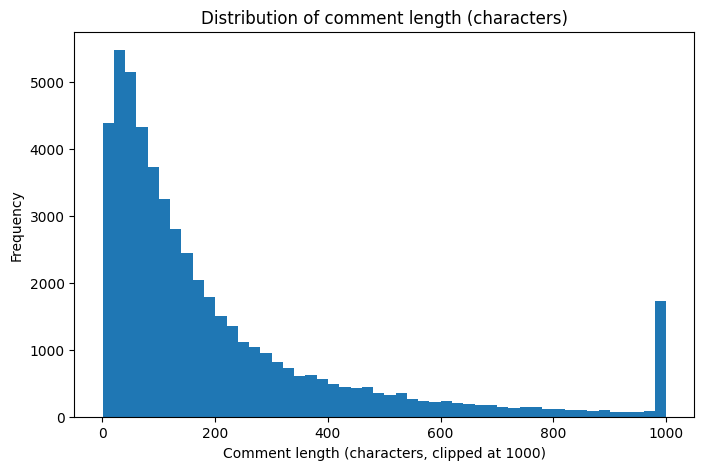

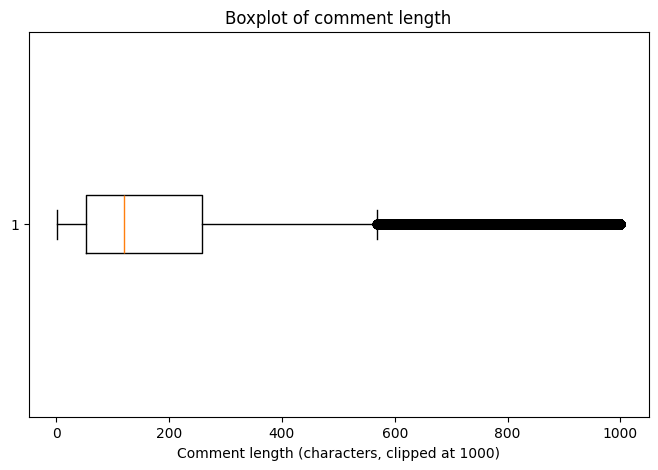

In [4]:
# 2. Comment length (characters and words)

# 2.1 Character length of the original comment body
df_clean['len_char'] = df_clean['comment_body'].astype(str).str.len()

# 2.2 Word count (very simple split on whitespace)
df_clean['len_word'] = df_clean['comment_body'].astype(str).str.split().apply(len)

# 2.3 Descriptive statistics for length
print("\n=== Character length statistics ===")
print(df_clean['len_char'].describe())

print("\n=== Word count statistics ===")
print(df_clean['len_word'].describe())

# 2.4 Histogram of character length (clipped to avoid extreme long-tail)
plt.figure()
len_char_clipped = df_clean['len_char'].clip(0, 1000)  # cap at 1000 for visualization
plt.hist(len_char_clipped, bins=50)
plt.xlabel("Comment length (characters, clipped at 1000)")
plt.ylabel("Frequency")
plt.title("Distribution of comment length (characters)")
plt.show()

# 2.5 Boxplot of character length
plt.figure()
plt.boxplot(len_char_clipped, vert=False)
plt.xlabel("Comment length (characters, clipped at 1000)")
plt.title("Boxplot of comment length")
plt.show()


           len_char   len_cleaned
count  52412.000000  52412.000000
mean     227.917500    134.672003
std      362.265989    219.336428
min        1.000000      0.000000
25%       53.000000     30.000000
50%      120.000000     69.000000
75%      259.000000    153.000000
max     8604.000000   6524.000000


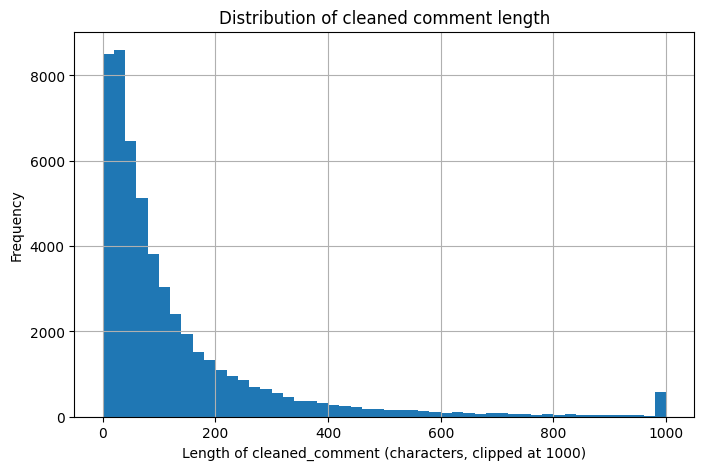

In [5]:
df_clean['len_cleaned'] = df_clean['cleaned_comment'].fillna("").astype(str).str.len()

print(df_clean[['len_char', 'len_cleaned']].describe())

plt.figure()
df_clean['len_cleaned'].clip(0, 1000).hist(bins=50)
plt.xlabel("Length of cleaned_comment (characters, clipped at 1000)")
plt.ylabel("Frequency")
plt.title("Distribution of cleaned comment length")
plt.show()

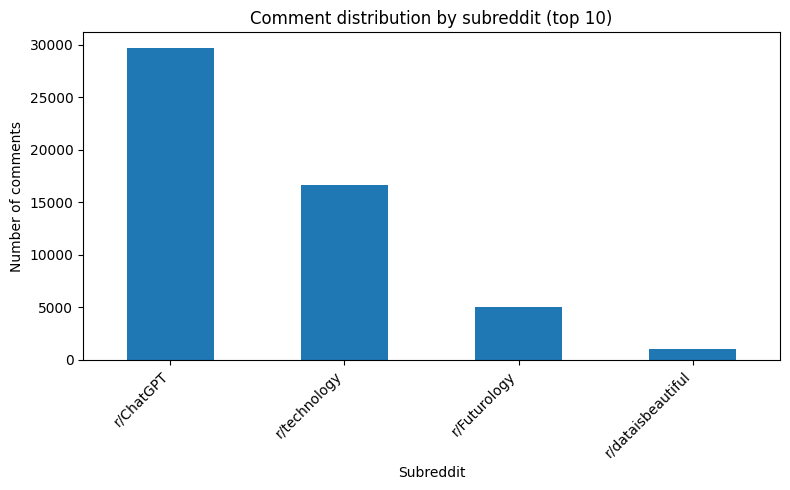


=== Comment length by subreddit ===
                   count        mean  median
subreddit                                   
r/ChatGPT          29711  212.221332   103.0
r/technology       16672  243.793546   139.0
r/Futurology        5009  275.016171   161.0
r/dataisbeautiful   1020  194.335294   109.0


<Figure size 800x500 with 0 Axes>

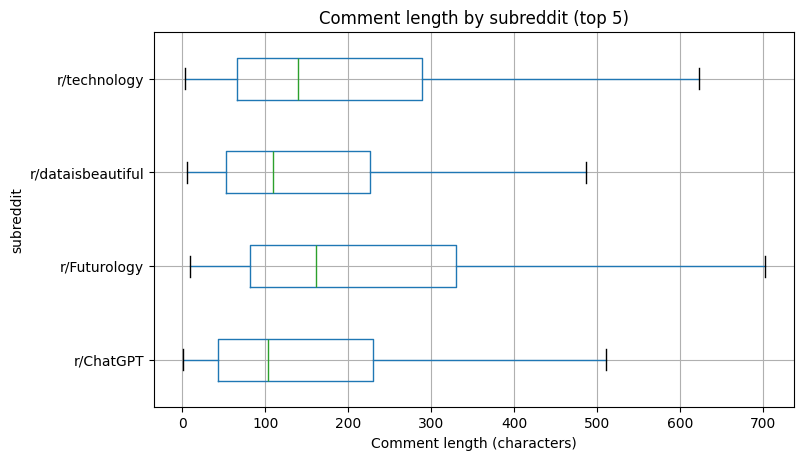

In [8]:
# 3.0 Subreddit frequency distribution 
sub_counts = df_clean['subreddit'].value_counts()

plt.figure()
sub_counts.head(10).plot(kind='bar')
plt.xlabel("Subreddit")
plt.ylabel("Number of comments")
plt.title("Comment distribution by subreddit (top 10)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# 3.1 Aggregated stats by subreddit
length_by_subreddit = (
    df_clean
    .groupby('subreddit')['len_char']
    .agg(['count', 'mean', 'median'])
    .sort_values('count', ascending=False)
)

print("\n=== Comment length by subreddit ===")
print(length_by_subreddit)

# 3.2 Boxplot of length for top N subreddits (by count)
top_n = 5
top_subreddits = length_by_subreddit.head(top_n).index.tolist()

plt.figure()
df_clean[df_clean['subreddit'].isin(top_subreddits)].boxplot(
    column='len_char',
    by='subreddit',
    showfliers=False,   # hide extreme outliers for clearer plot
    vert=False
)
plt.suptitle("")  # remove the automatic title
plt.xlabel("Comment length (characters)")
plt.title(f"Comment length by subreddit (top {top_n})")
plt.show()


=== parent_type value counts (before dropping 'other') ===
parent_type
t1    37562
t3    14850
Name: count, dtype: int64

=== parent_type value counts (after dropping 'other') ===
parent_type
t1    37562
t3    14850
Name: count, dtype: int64


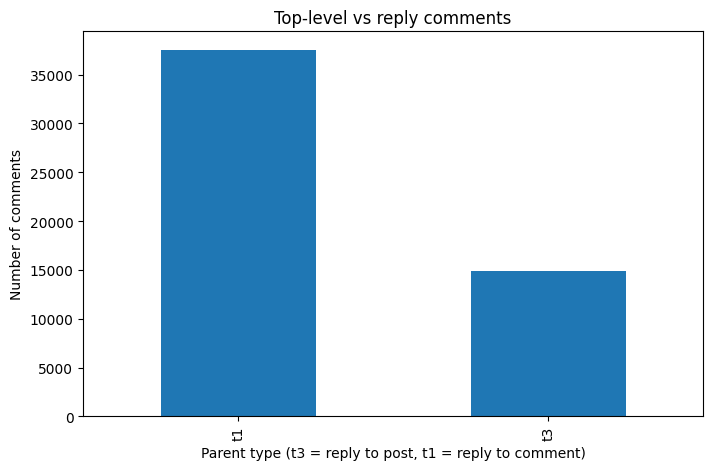


=== Comment length by parent_type ===
             count        mean  median
parent_type                           
t1           37562  235.989165   128.0
t3           14850  207.500808   101.0


In [9]:
# 4. top-level vs reply comments
# 4.1 Identify parent type using comment_parent_id
# t3_... -> reply to post (top-level)
# t1_... -> reply to another comment
df_clean['comment_parent_id'] = df_clean['comment_parent_id'].astype(str).fillna("")

df_clean['parent_type'] = df_clean['comment_parent_id'].str[:2]
df_clean['parent_type'] = df_clean['parent_type'].where(
    df_clean['parent_type'].isin(['t1', 't3']),
    'other'
)

print("\n=== parent_type value counts (before dropping 'other') ===")
print(df_clean['parent_type'].value_counts())

# 4.2 Bar plot: number of comments by parent_type
parent_counts = df_clean['parent_type'].value_counts()

df_clean = df_clean[df_clean['parent_type'].isin(['t1', 't3'])].copy()

print("\n=== parent_type value counts (after dropping 'other') ===")
print(df_clean['parent_type'].value_counts())

plt.figure()
parent_counts.plot(kind='bar')
plt.xlabel("Parent type (t3 = reply to post, t1 = reply to comment)")
plt.ylabel("Number of comments")
plt.title("Top-level vs reply comments")
plt.show()

# 4.3 Compare average length by parent_type
length_by_parent = df_clean.groupby('parent_type')['len_char'].agg(['count', 'mean', 'median'])
print("\n=== Comment length by parent_type ===")
print(length_by_parent)


=== Top 20 unigrams ===
      ngram  count
0       use  10794
1        ai   9960
2      like   9648
3   chatgpt   9431
4       get   8697
5      make   7969
6    people   7254
7     would   6827
8     write   6623
9     think   6523
10     work   6100
11     dont   5750
12       go   5625
13      say   5541
14       im   5222
15     know   5217
16    thing   5208
17      one   5121
18     time   4993
19      ask   4941


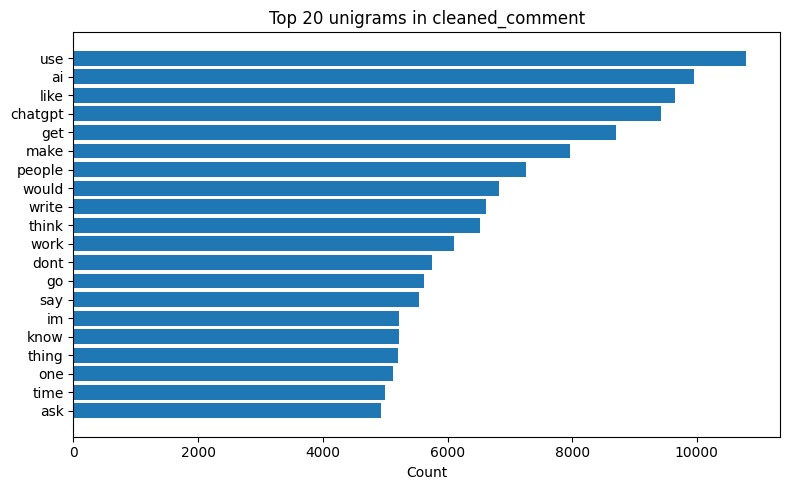


=== Top 20 bigrams ===
              ngram  count
0    language model    849
1       use chatgpt    769
2         dont know    736
3          chat gpt    635
4        dont think    616
5            gon na    513
6     search engine    508
7         feel like    507
8           im sure    507
9            use ai    481
10       sound like    461
11        look like    442
12   something like    431
13     ask question    399
14     cover letter    398
15      ask chatgpt    394
16  answer question    391
17        seem like    362
18       make sense    346
19      write essay    345


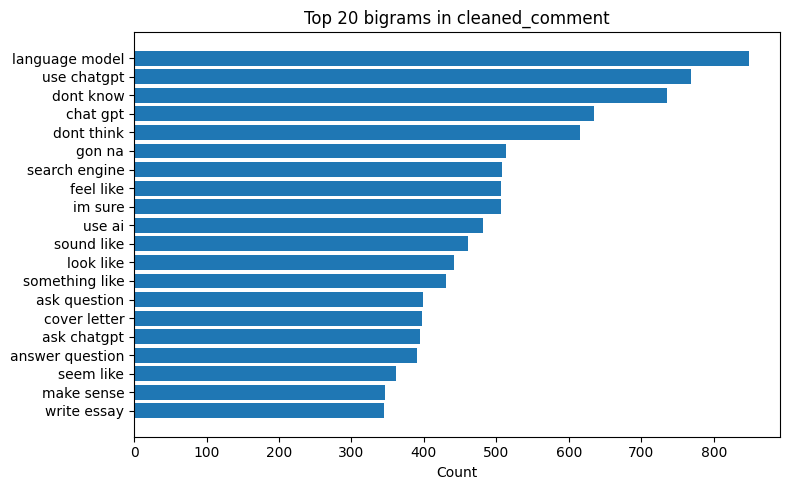

In [10]:
# 5. Text content EDA: frequent tokens and n-grams

def get_top_ngrams(corpus, ngram_range=(1, 1), top_k=20, min_df=5):
    """
    Compute top-k n-grams for a given corpus using CountVectorizer.

    Parameters:
        corpus: list of strings
        ngram_range: (min_n, max_n), e.g. (1,1) for unigram, (2,2) for bigram
        top_k: how many n-grams to return
        min_df: minimum number of documents in which the n-gram must appear

    Returns:
        DataFrame with columns ['ngram', 'count']
    """
    vectorizer = CountVectorizer(
        ngram_range=ngram_range,
        min_df=min_df,
    )
    X = vectorizer.fit_transform(corpus)
    counts = np.array(X.sum(axis=0))[0]
    vocab = np.array(vectorizer.get_feature_names_out())

    indices = counts.argsort()[::-1]  # descending order
    top_ngrams = vocab[indices][:top_k]
    top_counts = counts[indices][:top_k]

    result = pd.DataFrame({
        'ngram': top_ngrams,
        'count': top_counts
    })
    return result

# 5.1 Prepare the corpus (drop NaNs)
corpus = df_clean['cleaned_comment'].dropna().astype(str).tolist()

# 5.2 Top-20 unigrams
top_unigram = get_top_ngrams(corpus, ngram_range=(1, 1), top_k=20, min_df=5)
print("\n=== Top 20 unigrams ===")
print(top_unigram)

plt.figure()
plt.barh(top_unigram['ngram'][::-1], top_unigram['count'][::-1])
plt.xlabel("Count")
plt.title("Top 20 unigrams in cleaned_comment")
plt.tight_layout()
plt.show()

# 5.3 Top-20 bigrams
top_bigram = get_top_ngrams(corpus, ngram_range=(2, 2), top_k=20, min_df=5)
print("\n=== Top 20 bigrams ===")
print(top_bigram)

plt.figure()
plt.barh(top_bigram['ngram'][::-1], top_bigram['count'][::-1])
plt.xlabel("Count")
plt.title("Top 20 bigrams in cleaned_comment")
plt.tight_layout()
plt.show()


In [11]:
# 5.4 Keyword comparison by subreddit
target_subs = ['ChatGPT', 'technology', 'Futurology', 'dataisbeautiful']

for sub in target_subs:
    sub_mask = df_clean['subreddit'].str.contains(sub, case=False, na=False)
    sub_corpus = df_clean.loc[sub_mask, 'cleaned_comment'].dropna().astype(str).tolist()
    
    if len(sub_corpus) < 50:
        print(f"\n{sub}: too few samples, skipped.")
        continue
    
    print(f"\n=== {sub} - Top 10 unigrams ===")
    sub_top_unigram = get_top_ngrams(sub_corpus, ngram_range=(1, 1), top_k=10, min_df=3)
    print(sub_top_unigram)


=== ChatGPT - Top 10 unigrams ===
     ngram  count
0      use   5679
1     like   5152
2  chatgpt   4951
3       ai   4949
4      get   4562
5     make   4312
6    would   3591
7    think   3457
8   people   3281
9    write   3172

=== technology - Top 10 unigrams ===
     ngram  count
0      use   3746
1       ai   3251
2     like   3242
3  chatgpt   3156
4      get   3043
5   people   2841
6    write   2762
7     make   2714
8     work   2393
9    would   2326

=== Futurology - Top 10 unigrams ===
     ngram  count
0       ai   1674
1  chatgpt   1110
2     like   1076
3      use   1070
4      get    957
5   people    928
6   google    851
7     make    809
8    would    808
9    think    802

=== dataisbeautiful - Top 10 unigrams ===
     ngram  count
0      use    299
1  chatgpt    214
2   people    204
3     like    178
4      get    135
5     make    134
6    china    128
7    thing    115
8     work    105
9     know    104



=== Top 20 trigrams ===
      ngram  count
0       use  10794
1        ai   9960
2      like   9648
3   chatgpt   9431
4       get   8697
5      make   7969
6    people   7254
7     would   6827
8     write   6623
9     think   6523
10     work   6100
11     dont   5750
12       go   5625
13      say   5541
14       im   5222
15     know   5217
16    thing   5208
17      one   5121
18     time   4993
19      ask   4941


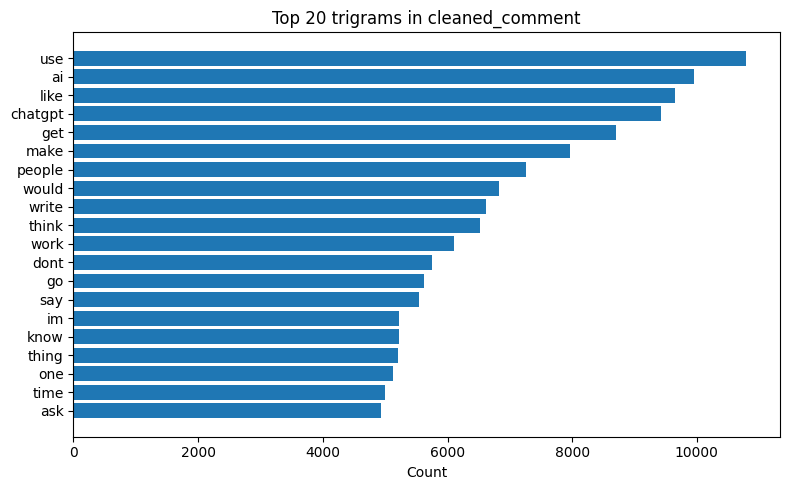

In [19]:
top_trigram = get_top_ngrams(corpus, ngram_range=(1, 1), top_k=20, min_df=5)
print("\n=== Top 20 trigrams ===")
print(top_trigram)

plt.figure()
plt.barh(top_trigram['ngram'][::-1], top_trigram['count'][::-1])
plt.xlabel("Count")
plt.title("Top 20 trigrams in cleaned_comment")
plt.tight_layout()
plt.show()


=== combined_label distribution ===
combined_label
positive    28820
neutral     10894
negative    12698
Name: count, dtype: int64


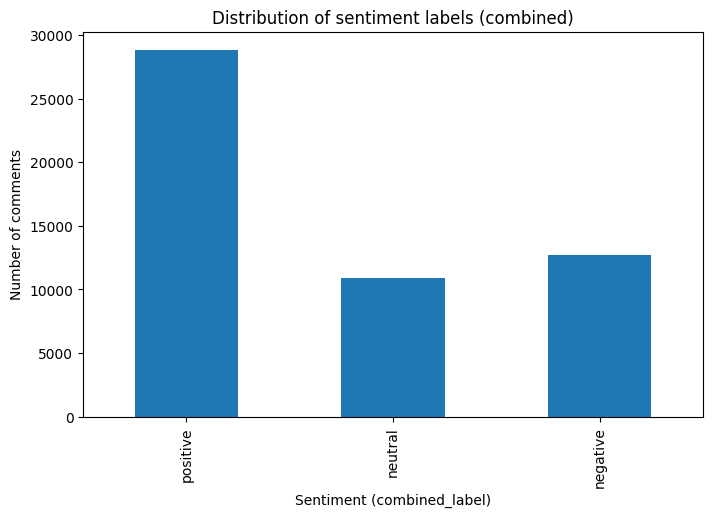

In [13]:
# 6. Sentiment label distribution (combined_label)

label_order = ['positive', 'neutral', 'negative']

combined_counts = df_clean['combined_label'].value_counts().reindex(label_order)
print("\n=== combined_label distribution ===")
print(combined_counts)

plt.figure()
combined_counts.plot(kind='bar')
plt.xlabel("Sentiment (combined_label)")
plt.ylabel("Number of comments")
plt.title("Distribution of sentiment labels (combined)")
plt.show()



=== TextBlob vs VADER label crosstab (counts) ===
vader_label     negative  neutral  positive
textblob_label                             
negative            4938     1239      2583
neutral             4077     9976      6778
positive            3185     2195     17441

=== TextBlob vs VADER label crosstab (proportions) ===
vader_label     negative  neutral  positive
textblob_label                             
negative           0.094    0.024     0.049
neutral            0.078    0.190     0.129
positive           0.061    0.042     0.333

=== Correlation between TextBlob and VADER scores ===
                textblob_score  vader_score
textblob_score        1.000000     0.430944
vader_score           0.430944     1.000000


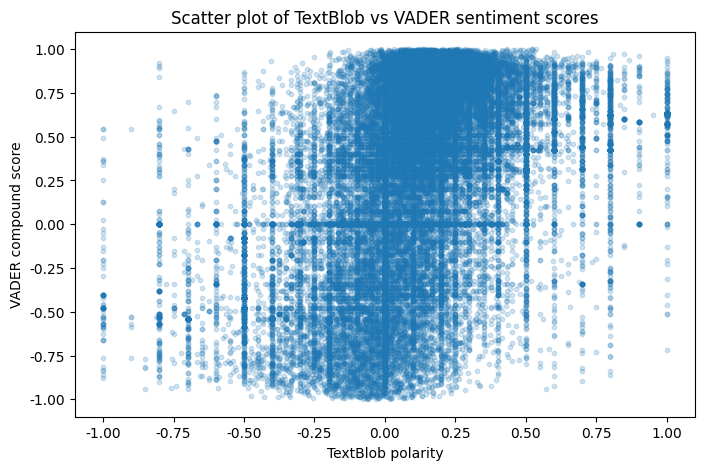

In [14]:
# 7. TextBlob vs VADER: label agreement
tb_vader_crosstab = pd.crosstab(df_clean['textblob_label'], df_clean['vader_label'])
print("\n=== TextBlob vs VADER label crosstab (counts) ===")
print(tb_vader_crosstab)

tb_vader_crosstab_norm = pd.crosstab(
    df_clean['textblob_label'],
    df_clean['vader_label'],
    normalize='all'
)
print("\n=== TextBlob vs VADER label crosstab (proportions) ===")
print(tb_vader_crosstab_norm.round(3))

corr_matrix = df_clean[['textblob_score', 'vader_score']].corr(method='pearson')
print("\n=== Correlation between TextBlob and VADER scores ===")
print(corr_matrix)
plt.figure()
plt.scatter(
    df_clean['textblob_score'],
    df_clean['vader_score'],
    alpha=0.2,
    s=10
)
plt.xlabel("TextBlob polarity")
plt.ylabel("VADER compound score")
plt.title("Scatter plot of TextBlob vs VADER sentiment scores")
plt.show()



=== Sentiment distribution by subreddit (counts) ===
combined_label     negative  neutral  positive
subreddit                                     
r/ChatGPT              6727     6828     16156
r/technology           4455     3056      9161
r/Futurology           1258      780      2971
r/dataisbeautiful       258      230       532

=== Sentiment distribution by subreddit (proportions) ===
combined_label     negative  neutral  positive
subreddit                                     
r/ChatGPT             0.226    0.230     0.544
r/technology          0.267    0.183     0.549
r/Futurology          0.251    0.156     0.593
r/dataisbeautiful     0.253    0.225     0.522


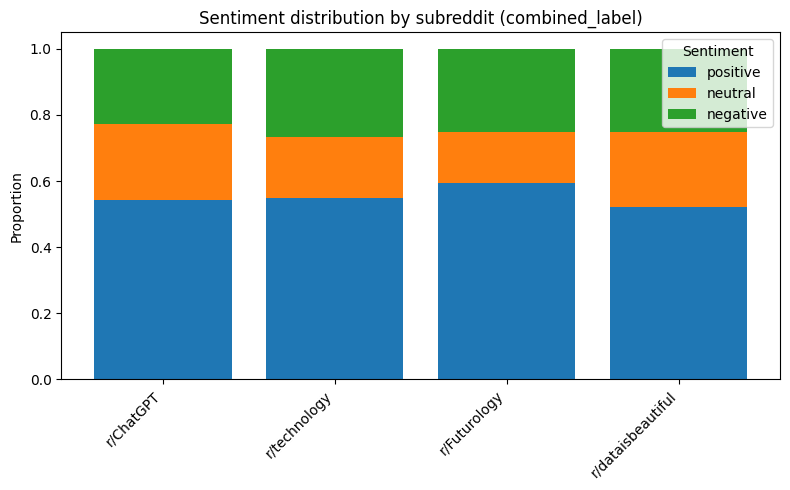


=== Comment length by sentiment ===
                count        mean  median
combined_label                           
negative        12698  228.253819   136.0
neutral         10894   72.876629    42.0
positive        28820  286.374983   160.0


<Figure size 800x500 with 0 Axes>

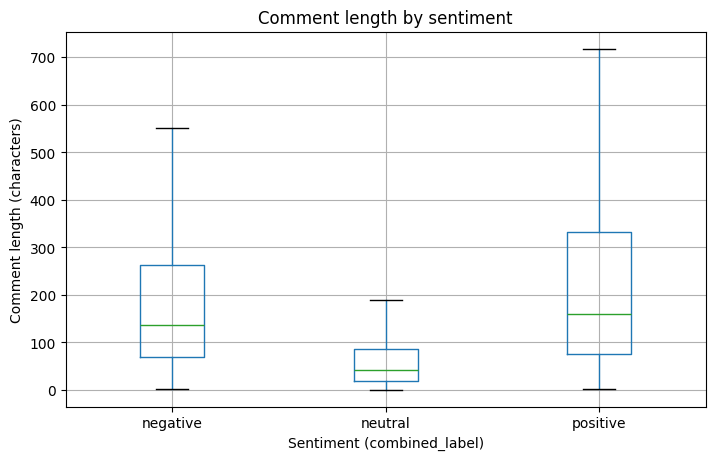


=== parent_type x sentiment (counts) ===
combined_label  negative  neutral  positive
parent_type                                
t1                  8952     7591     21019
t3                  3746     3303      7801

=== parent_type x sentiment (proportions) ===
combined_label  negative  neutral  positive
parent_type                                
t1                 0.238    0.202     0.560
t3                 0.252    0.222     0.525


In [15]:
# 8. Sentiment vs subreddit / length / hierarchy

# 8.1 Sentiment distribution by subreddit (top N subreddits)

sub_counts = df_clean['subreddit'].value_counts()
top_subs = sub_counts.head(5).index.tolist()

sent_by_sub = pd.crosstab(df_clean['subreddit'], df_clean['combined_label'])
sent_by_sub_top = sent_by_sub.loc[top_subs]

print("\n=== Sentiment distribution by subreddit (counts) ===")
print(sent_by_sub_top)

sent_by_sub_top_prop = sent_by_sub_top.div(sent_by_sub_top.sum(axis=1), axis=0)
print("\n=== Sentiment distribution by subreddit (proportions) ===")
print(sent_by_sub_top_prop.round(3))

# Stacked bar chart (proportions)
plt.figure()
bottom = np.zeros(len(top_subs))
for lbl in label_order:
    vals = sent_by_sub_top_prop[lbl].values
    plt.bar(top_subs, vals, bottom=bottom, label=lbl)
    bottom += vals

plt.xticks(rotation=45, ha='right')
plt.ylabel("Proportion")
plt.title("Sentiment distribution by subreddit (combined_label)")
plt.legend(title="Sentiment")
plt.tight_layout()
plt.show()

# 8.2 Comment length by sentiment label
length_by_sent = df_clean.groupby('combined_label')['len_char'].agg(['count', 'mean', 'median'])
print("\n=== Comment length by sentiment ===")
print(length_by_sent)

plt.figure()
df_clean.boxplot(column='len_char', by='combined_label', showfliers=False)
plt.suptitle("")
plt.xlabel("Sentiment (combined_label)")
plt.ylabel("Comment length (characters)")
plt.title("Comment length by sentiment")
plt.show()

# 8.3 Sentiment vs parent_type
sent_by_parent = pd.crosstab(df_clean['parent_type'], df_clean['combined_label'])
print("\n=== parent_type x sentiment (counts) ===")
print(sent_by_parent)

sent_by_parent_prop = sent_by_parent.div(sent_by_parent.sum(axis=1), axis=0)
print("\n=== parent_type x sentiment (proportions) ===")
print(sent_by_parent_prop.round(3))


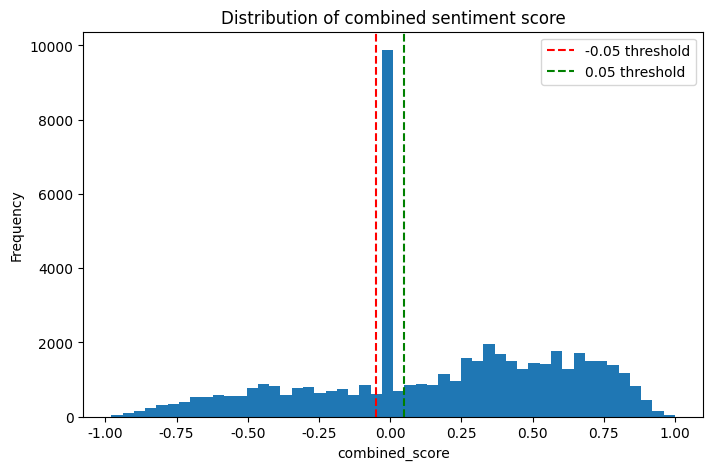

In [16]:
# 8.4 Distribution of combined_score with thresholds
plt.figure()
plt.hist(df_clean['combined_score'], bins=50)
plt.xlabel("combined_score")
plt.ylabel("Frequency")
plt.title("Distribution of combined sentiment score")

# draw threshold lines at -0.05 and 0.05
plt.axvline(x=-0.05, color='red', linestyle='--', label='-0.05 threshold')
plt.axvline(x=0.05, color='green', linestyle='--', label='0.05 threshold')

plt.legend()
plt.show()


In [17]:
# sample example comments from each sentiment class 
np.random.seed(42)
labels = ['positive', 'neutral', 'negative']

for lbl in labels:
    print(f"\n=== Example comments for label: {lbl} ===")
    
    subset = df_clean[df_clean['combined_label'] == lbl]
    n_samples = min(3, len(subset))
    examples = subset.sample(n_samples)

    for _, row in examples.iterrows():
        score = row['combined_score']
        text = row['comment_body']  # or 'cleaned_comment'
        print(f"\n[combined_score = {score:.3f}]")
        print(text[:500])  # in case it's very long, print first 500 chars



=== Example comments for label: positive ===

[combined_score = 0.251]
Half the people in Congress graduated law school, the bar is pretty low.

[combined_score = 0.135]
A certain level of cheating is tolerated, as in a few wealthy kids paying someone to write their paper. Half the class asking ChatGPT to write the paper for them is not.

That is generally true in life. We tolerate a certain level of crime and rulebreaking, only responding if it gets too common.

[combined_score = 0.792]
According to some people in that field they claim that at some point emotions will be available by a push of a button. You want to feel in love? its done you are in love with a particular person. You are heartbroken? not anymore. So yea this is pretty scary

Allthough I doubt it would work like that always. Like there is emotion and logic and memory. For example you know you broke up at bad terms. The emotion an AI might influence might make that memory more or less cloudy/foggy, but the choice 

=== 

In [21]:
!pip install wordcloud

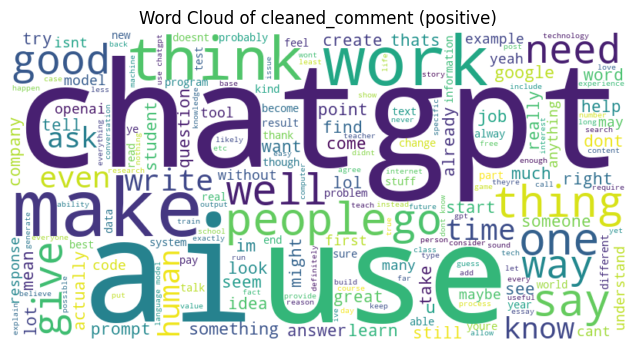

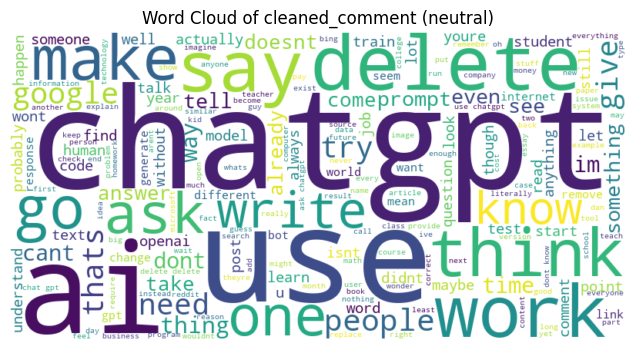

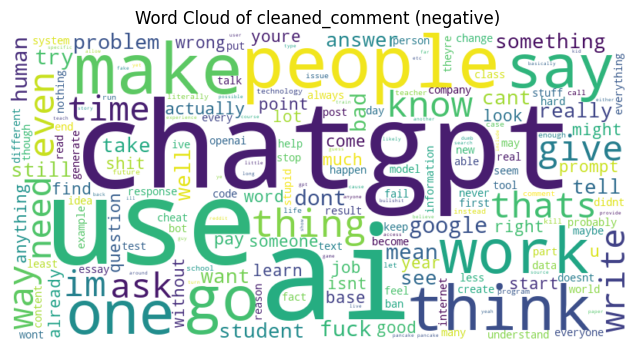

In [26]:
from wordcloud import WordCloud

def plot_wordcloud(text_series, title):
 
    text = " ".join(text_series.dropna().astype(str))
    wc = WordCloud(
        width=800,
        height=400,
        background_color="white"
    ).generate(text)

    plt.figure(figsize=(8, 4))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(title)
    plt.show()

sentiment_categories = ['positive', 'neutral', 'negative']

for lbl in sentiment_categories:
    sub_text = df_clean.loc[df_clean['combined_label'] == lbl, 'cleaned_comment']
    plot_wordcloud(sub_text, title=f"Word Cloud of cleaned_comment ({lbl})")


In [27]:
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd

def get_top_ngrams(corpus, ngram_range=(1,1), top_k=20, min_df=5):
  vectorizer = CountVectorizer(
        ngram_range=ngram_range,
        min_df=min_df
    )
    X = vectorizer.fit_transform(corpus)

    freqs = X.sum(axis=0).A1
    vocab = vectorizer.get_feature_names_out()
    
    df_freq = pd.DataFrame({
        "ngram": vocab,
        "count": freqs
    }).sort_values("count", ascending=False).head(top_k)
    
    return df_freq



=== Top 15 bigrams in cleaned_comment (positive) ===
                 ngram  count
7230    language model    636
14491      use chatgpt    544
3528         dont know    506
6423           im sure    445
3558        dont think    442
12251       sound like    406
4400         feel like    398
1965          chat gpt    397
11607    search engine    363
7980         look like    359
12165   something like    350
14460           use ai    325
5360            gon na    307
11763        seem like    298
914    answer question    284


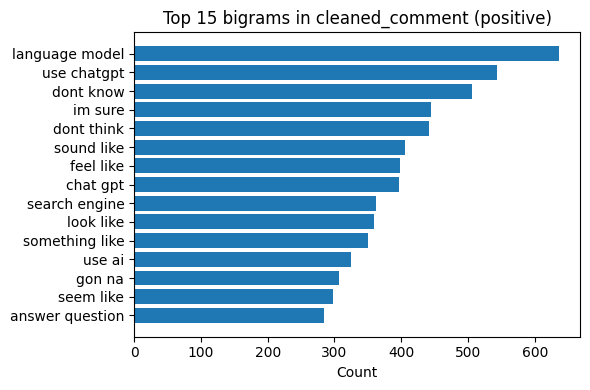


=== Top 15 bigrams in cleaned_comment (neutral) ===
              ngram  count
73         chat gpt     93
462     use chatgpt     73
44      ask chatgpt     70
150       dont know     62
357    remindme day     52
123    cover letter     50
99    chatgpt write     50
219          gon na     49
156      dont think     48
375   search engine     47
261  language model     42
47     ask question     40
514   write chatgpt     36
456          use ai     35
292      make sense     35


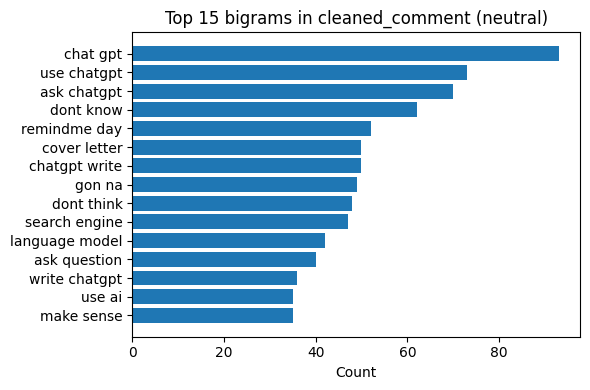


=== Top 15 bigrams in cleaned_comment (negative) ===
                ngram  count
1783   language model    171
889         dont know    168
1368           gon na    157
3435      use chatgpt    152
504          chat gpt    145
905        dont think    126
909         dont want    124
3428           use ai    121
3845         year ago    100
2801    search engine     98
297      ask question     93
1592         im sorry     92
1102        feel like     91
740      cover letter     90
238   answer question     90


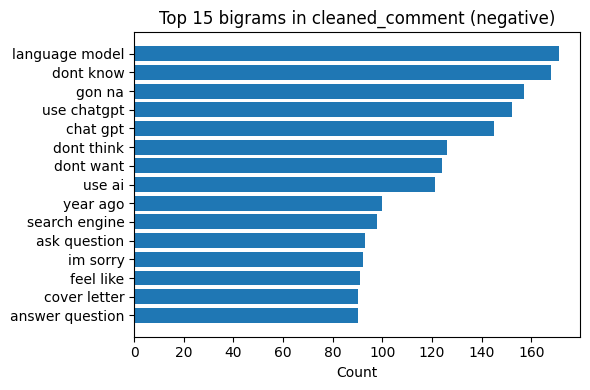

In [31]:
sentiment_categories = ['positive', 'neutral', 'negative']

for lbl in sentiment_categories:
    print(f"\n=== Top 15 bigrams in cleaned_comment ({lbl}) ===")

    sub_corpus = df_clean.loc[df_clean['combined_label'] == lbl, 'cleaned_comment'] \
                          .dropna().astype(str).tolist()
    
    if len(sub_corpus) == 0:
        print("No samples for this label.")
        continue

    top_bigram = get_top_ngrams(
        sub_corpus,
        ngram_range=(2, 2),  
        top_k=15,
        min_df=5     
    )
    print(top_bigram)

    plt.figure(figsize=(6, 4))
    plt.barh(top_bigram['ngram'][::-1], top_bigram['count'][::-1])
    plt.xlabel("Count")
    plt.title(f"Top 15 bigrams in cleaned_comment ({lbl})")
    plt.tight_layout()
    plt.show()



=== Top 10 trigrams in cleaned_comment (positive) ===
                                                  ngram  count
670                                  bot action perform    138
76                         action perform automatically    138
573                        automatically please contact    137
3773                           please contact moderator    137
3720                       perform automatically please    137
1036  contact moderator subredditmessagecomposetorch...    131
3954                              public discord server    131
4652  subredditmessagecomposetorchatgpt question con...    131
3338  moderator subredditmessagecomposetorchatgpt qu...    131
3369                        multiple repetitive comment    131


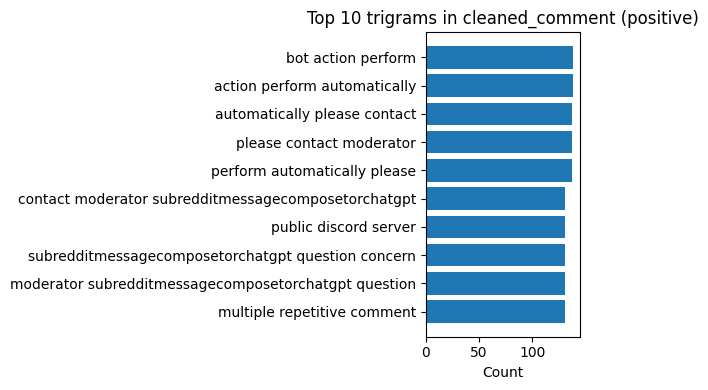


=== Top 10 trigrams in cleaned_comment (neutral) ===
                          ngram  count
117                use chat gpt     17
129          write cover letter     15
118           use chatgpt write     11
70         large language model     10
23               chat gpt write     10
14            ask chatgpt write      9
62                    im gon na      9
33   comment alphabetical order      8
71              law school exam      7
77              make video make      7


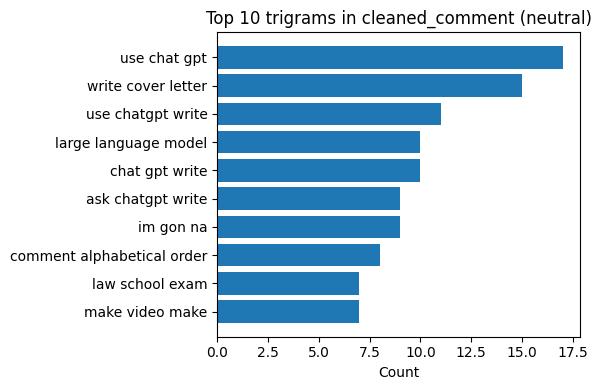


=== Top 10 trigrams in cleaned_comment (negative) ===
                             ngram  count
697           large language model     46
606                      im gon na     25
691           language model train     25
811             model train openai     20
1132           student use chatgpt     16
1241             use chatgpt write     15
753            machine learn model     15
1233                  use chat gpt     14
287        critical thinking skill     14
266   convolutional neural network     14


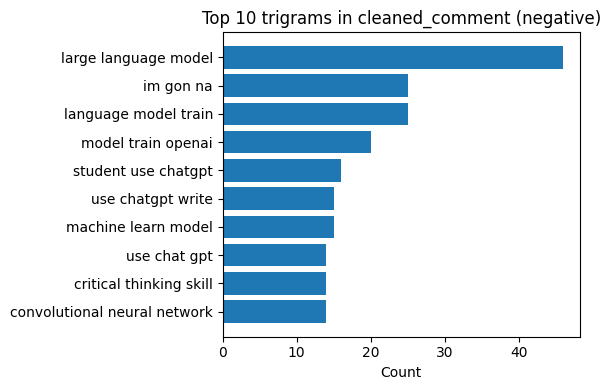

In [32]:
for lbl in sentiment_categories:
    print(f"\n=== Top 10 trigrams in cleaned_comment ({lbl}) ===")
    
    sub_corpus = df_clean.loc[df_clean['combined_label'] == lbl, 'cleaned_comment'] \
                          .dropna().astype(str).tolist()
    
    if len(sub_corpus) == 0:
        print("No samples for this label.")
        continue
    
    top_trigram = get_top_ngrams(
        sub_corpus,
        ngram_range=(3, 3),  
        top_k=10,
        min_df=3
    )
    print(top_trigram)
    
    plt.figure(figsize=(6, 4))
    plt.barh(top_trigram['ngram'][::-1], top_trigram['count'][::-1])
    plt.xlabel("Count")
    plt.title(f"Top 10 trigrams in cleaned_comment ({lbl})")
    plt.tight_layout()
    plt.show()

In [4]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

text = " ".join(text_series.dropna().astype(str))
wc = WordCloud(width=800, height=400, background_color="white",
               stopwords=stopwords_list, max_words=200).generate(text)

plt.figure(figsize=(10,5))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()



NameError: name 'text_series' is not defined